In [1]:
import sys
import os
from pathlib import Path 
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt
import pickle
modulepath = Path.cwd().parent / "utils"
modulepath = str(modulepath)
projectpath = Path.cwd().parent
projectpath = str(projectpath)
if modulepath not in sys.path:
    sys.path.insert(0,str(modulepath))
if projectpath not in sys.path:
    sys.path.insert(0,str(projectpath))  
print(sys.path)


['c:\\Users\\oriol\\GitHub_Repos\\CNN-classification', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\utils', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\python312.zip', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\DLLs', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126', '', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\Pythonwin']


In [2]:
from utils.data_loaders import create_train_test_dataloaders
transform = v2.Compose([v2.RandomCrop(size=(20, 20))])#,v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


In [4]:
train_basic,test_basic = create_train_test_dataloaders(dataset_name="FashionMNIST",size=0.1)
train_augmented,test_augmented = create_train_test_dataloaders(dataset_name="FashionMNIST",transform=transform)
img_basic,label_basic = next(iter(train_basic))
img_augmented,label_augmented = next(iter(train_augmented))

32


In [4]:
train_basic,test_basic = create_train_test_dataloaders("some spaces are good")

print(train_basic.dataset.root.split("\\")[-1])
name = os.path.split(os.path.normpath(train_basic.dataset.root))[-1]
print(name)

some spaces are good
some spaces are good


(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

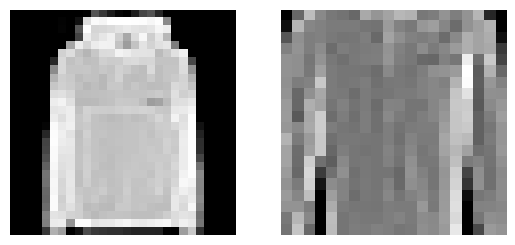

In [5]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_basic[0].permute(1,2,0),cmap="gray")
ax[1].imshow(img_augmented[0].permute(1,2,0),cmap="gray")
ax[0].axis(False)
ax[1].axis(False)

In [6]:
img_basic.shape

torch.Size([32, 1, 28, 28])

In [7]:
from utils.model_architectures import TinyVGG_1
from torchinfo import summary 

tvgg = TinyVGG_1(1,20,10)

In [8]:
summary(tvgg,input_size=[32,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG_1                                [32, 10]                  --
├─Sequential: 1-1                        [32, 20, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 20, 26, 26]          200
│    └─ReLU: 2-2                         [32, 20, 26, 26]          --
│    └─Conv2d: 2-3                       [32, 20, 24, 24]          3,620
│    └─ReLU: 2-4                         [32, 20, 24, 24]          --
│    └─MaxPool2d: 2-5                    [32, 20, 12, 12]          --
├─Sequential: 1-2                        [32, 20, 4, 4]            --
│    └─Conv2d: 2-6                       [32, 20, 10, 10]          3,620
│    └─ReLU: 2-7                         [32, 20, 10, 10]          --
│    └─Conv2d: 2-8                       [32, 20, 8, 8]            3,620
│    └─ReLU: 2-9                         [32, 20, 8, 8]            --
│    └─MaxPool2d: 2-10                   [32, 20, 4, 4]            --
├─Seq

In [9]:
tvgg.cpu()
tvgg.forward(img_basic[0].unsqueeze(dim=0))
torch.softmax(tvgg.forward(img_basic[0].unsqueeze(dim=0)),1)

#next(tvgg.parameters()).is_cuda #check if model on cuda

tensor([[0.1039, 0.0984, 0.0970, 0.0983, 0.0958, 0.0985, 0.1001, 0.1020, 0.1042,
         0.1018]], grad_fn=<SoftmaxBackward0>)

In [8]:
from utils.engine import train
from utils.model_architectures import TinyVGG_1
from utils.data_loaders import create_train_test_dataloaders
from torch import nn
from utils.helpers import create_writer
from utils.helpers import create_experiment_metadata
train_dataloader, test_dataloader = create_train_test_dataloaders(size=0.1) #type: ignore
    
device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)
#print(f"Is the model on GPU {next(model_0.parameters()).is_cuda}")

model_name = model_0._get_name()
experiment_name = "Test_small_dataset"
extra = "1 epochs"
NUM_EPOCHS = 1

writer = create_writer(experiment_name=experiment_name,model_name=model_name,extra=extra)

train(model=model_0,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=NUM_EPOCHS,writer=writer)


[INFO] Created SummaryWriter, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs\TinyVGG_1\Test_small_dataset\1 epochs...
[INFO] Created experiment metadata, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs_metadata\TinyVGG_1\Test_small_dataset\1 epochs...


  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
from utils.data_loaders import create_train_test_dataloaders
from torchvision import datasets 
from utils.config import DATA_DIRECTORY
mnist = os.path.join(DATA_DIRECTORY,"FashionMNIST")
train_dataset = datasets.FashionMNIST(root=mnist,train=True,download=False,transform=v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True)]))
train_basic,test_basic = create_train_test_dataloaders("FashionMNIST")


In [ ]:
print(f"Initial len {len(train_dataset)}, initial type {type(train_dataset)}")
size = 0.1
nel = int(len(train_dataset)*size)
train_dataset.data = train_dataset.data[0:nel]
print(f"Final len {len(train_dataset)}, final type {type(train_dataset)}")


Initial len 600, initial type <class 'torchvision.datasets.mnist.FashionMNIST'>
470400
Final len 60, final type <class 'torchvision.datasets.mnist.FashionMNIST'>


In [2]:
from utils.config import RUNS_METADATA_DIRECTORY
from utils.config import METADATA_FILENAME

def retrieve_metadata(model_name:str, experiment_name:str, extra=None):
    """AAA"""
    if extra:
        metadata_path = os.path.join(RUNS_METADATA_DIRECTORY, model_name, 
                               experiment_name, extra, METADATA_FILENAME)
    else:
        metadata_path = os.path.join(RUNS_METADATA_DIRECTORY, model_name, 
                               experiment_name, METADATA_FILENAME)
    if os.path.exists(metadata_path):
        with open(metadata_path, 'rb') as file:
            metadata = pickle.load(file)
        return metadata
    else:
        print(f"No metadata stored in {metadata_path}")

In [8]:

meta_dict = retrieve_metadata(model_name="TinyVGG_1", experiment_name="iwhrsgir", extra="3 epochs SDG")


No metadata stored in c:\Users\oriol\GitHub_Repos\CNN-classification\runs_metadata\TinyVGG_1\iwhrsgir\3 epochs SDG\Metadata.pkl


In [7]:
print(meta_dict)

{'date': '20-08-2025', 'experiment name': 'Test_writer_and_metadata', 'model name': 'TinyVGG_1', 'learning rate': 0.01, 'epochs': 3, 'loss function': 'CrossEntropyLoss', 'optimizer name': 'SGD', 'dataset': 'some spaces are good', 'training dataset size': 60000, 'testing dataset size': 10000, 'batch size': 32, 'optimizer params': {'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None}, 'model params': {'layer_1': Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), 'layer_2': Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [71]:
from utils.config import RUNS_DIRECTORY
print(RUNS_DIRECTORY)
exlog = os.path.dirname(RUNS_DIRECTORY)
print(exlog)
if exlog not in sys.path:
    sys.path.insert(0,str(exlog))
print(sys.path)

c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs
c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs
['c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\experiment_logs', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\experiment_logs\\runs', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\utils', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\python312.zip', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\DLLs', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126', '', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\Pythonwin']


In [ ]:
from utils.engine import train
from utils.model_architectures import TinyVGG_1
from utils.data_loaders import create_train_test_dataloaders
from torch import nn
from utils.helpers import create_writer
from utils.helpers import create_experiment_metadata
train_dataloader, test_dataloader = create_train_test_dataloaders()

device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [ ]:
optimizer.__getstate__()['defaults']

In [ ]:
model_0.__getstate__()['_modules']

In [ ]:
import pickle
with open(r"C:\Users\oriol\GitHub_Repos\CNN-classification\runs_metadata\TinyVGG_1\Test_writer_and_dict\2 epochs\Metadata.pkl", 'rb') as file:
    meta_dict = pickle.load(file)

In [ ]:
print(meta_dict)

In [ ]:
wrtr.__getstate__()['log_dir']

In [ ]:
import os
from utils.config import RUNS_DIRECTORY
from utils.helpers import create_writer
wrtr = create_writer(model_name="None",experiment_name="Test expname extraction",extra="Please")

relpath = os.path.normpath(os.path.relpath(wrtr.__getstate__()['log_dir'],RUNS_DIRECTORY))
components = relpath.split(os.sep)

In [ ]:
print(f"Model name '{components[0]}' and experiment name '{components[1]}'")
type(components[0])

In [ ]:
from utils.model_architectures import TinyVGG_1

device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)

In [ ]:
from utils.config import RUNS_METADATA_DIRECTORY
dictpath = os.path.join(RUNS_METADATA_DIRECTORY,relpath)
print(dictpath)

In [ ]:
import os
from utils.config import RUNS_METADATA_DIRECTORY
import pickle
metadata_file = os.path.join(RUNS_METADATA_DIRECTORY,"TinyVGG_1","Test_writer_and_newdict","1 epochs","Metadata.pkl")
with open(metadata_file, 'rb') as f:
    resdict = pickle.load(f)

In [10]:
from utils.model_architectures import TinyVGG_1
loaded_model = TinyVGG_1(1,10,10)
loaded_model.load_state_dict(torch.load(f=r"C:\Users\oriol\GitHub_Repos\CNN-classification\models\Untrained_TinyVGG_1.pth")) 

<All keys matched successfully>

In [123]:
HYPERPARAMETERS = {'Hidden Channels': [20,40,60,80,100],
                   'Epochs': [10,20],
                   'lr': [0.01,0.001],
                   'padding': [0,1],
                   'Fifth': ['A','B','C','D']
                   }


In [ ]:
#Rethink the tensorboard structure

#Write all HYPERPARAMETERS in extra

#Pros of writing all HYPERPARAMETERS in extra
    #Easy filtering by hyperparameter values
#Cons
    #If I want to add 1 more in the future it will be missing from all older experiment names
    #Long names

#I choose HYPERPARAMETERS by model architecture then it is less releavnt since there will be less changes 
#within the same architecture

#Maybe store the loss and accuracy as a panda dataframe with a column for
#Exp number (ID), HYPERPARAMETERS (the combination used for the experiment or more idk), exp name, model name, ... test acc, test loss, trsin acc, train loss

#Exp number should be mutable or immutable?
#Decide it when I create the Metadata.pkl file or when I load the dataframe?
#If I decide it when creating the metadata, how do I keep trak of experiment number between different days or sessions?

#One column for epoch (1,2,3,...) and another for number of epochs (fixed, 20 or smth)

#Broad idea is 
#to store the metadata (same as now)
#log to tensorboard (same as now)
#create dataframe with column names and values of acc and hyperparameters
#save the dataframe as a parquet or feather with column names depending on experiment (new)

#The files are all saved in one folder, and when I want to access the database I load them all and join them as pd dataframes. 
    #might want to add a load filter
#The files will be stored in a folder /experiment_results and the names will be 
    # model_name-experiment_name-extra

#I will need to deal with dataframes with different number of columns, so remember types of joins. 

#Then do a dataframe filter and plotter :)

#PROBLEMS

    #How to do a useful legend for so many plots 

In [ ]:
#For filtering filenames 

#names = [os.path.basename(x) for x in glob.glob('/your_path')] 
# makes glob return only filenames instead of the whole path 

In [2]:
from utils.engine import train
from utils.model_architectures import TinyVGG_1
from utils.data_loaders import create_train_test_dataloaders
from torch import nn
from utils.helpers import create_writer
from utils.helpers import create_dataframe
from utils.helpers import hyperparameter_combinations
from utils.helpers import save_dataframe
from utils.helpers import create_and_save_experiment_metadata

device = "cuda" if torch.cuda.is_available() else "cpu"

HYPERPARAMETERS = {'Hidden_Channels': [40],
                   'Epochs': [2],
                   'lr': [0.01,0.001],
                   }

experiment_name = "Test_new_metadata"
hp_combinations = hyperparameter_combinations(HYPERPARAMETERS)

for n,combination in enumerate(hp_combinations):
    HIDDEN_CHANNELS = combination[0]
    NUM_EPOCHS = combination[1]
    LR = combination[2]

    train_dataloader, test_dataloader = create_train_test_dataloaders(size=0.1) #type: ignore

    model_0 = TinyVGG_1(input_shape=1,hidden_channels=HIDDEN_CHANNELS,output_shape=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model_0.parameters(),lr=LR)

    #model_name = model_0._get_name()
    model_name = "Model_3"

    extra = ""
    namelist = [str(key)+"_"+str(val)+"_" for key,val in zip(HYPERPARAMETERS.keys(),combination)]
    for elem in namelist:
        extra += elem
    extra = extra[:-1]

    # Create a writer to save results to tensorboard
    writer = create_writer(experiment_name=experiment_name,
                           model_name=model_name,
                           extra=extra)
    # Train the model for a number of epochs and log the results to tensorboard
    results = train(model=model_0,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    writer=writer)
    # Store additional information on the experiment
    create_and_save_experiment_metadata(experiment_name=experiment_name,
                                        model_name=model_name,
                                        extra=extra,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader,
                                        model=model_0,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=NUM_EPOCHS,
                                        hyperparameters_tuple=combination,
                                        hyperparameters_keys=HYPERPARAMETERS.keys()
                                        )
    # Store the results of the accuracy and loss as a dataframe
    df = create_dataframe(results=results,
                          hyperparameters_tuple=combination,
                          hyperparameters_keys=HYPERPARAMETERS.keys())
    save_dataframe(df=df,
                   model_name=model_name,
                   experiment_name=experiment_name,
                   extra=extra)


[INFO] Created SummaryWriter, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.01...


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Created experiment metadata, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\results\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.01...
[INFO] Saving the above results to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\results\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.01\Results.feather
[INFO] Created SummaryWriter, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.001...


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Created experiment metadata, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\results\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.001...
[INFO] Saving the above results to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\results\Test_new_metadata\Model_3\Hidden_Channels_40_Epochs_2_lr_0.001\Results.feather


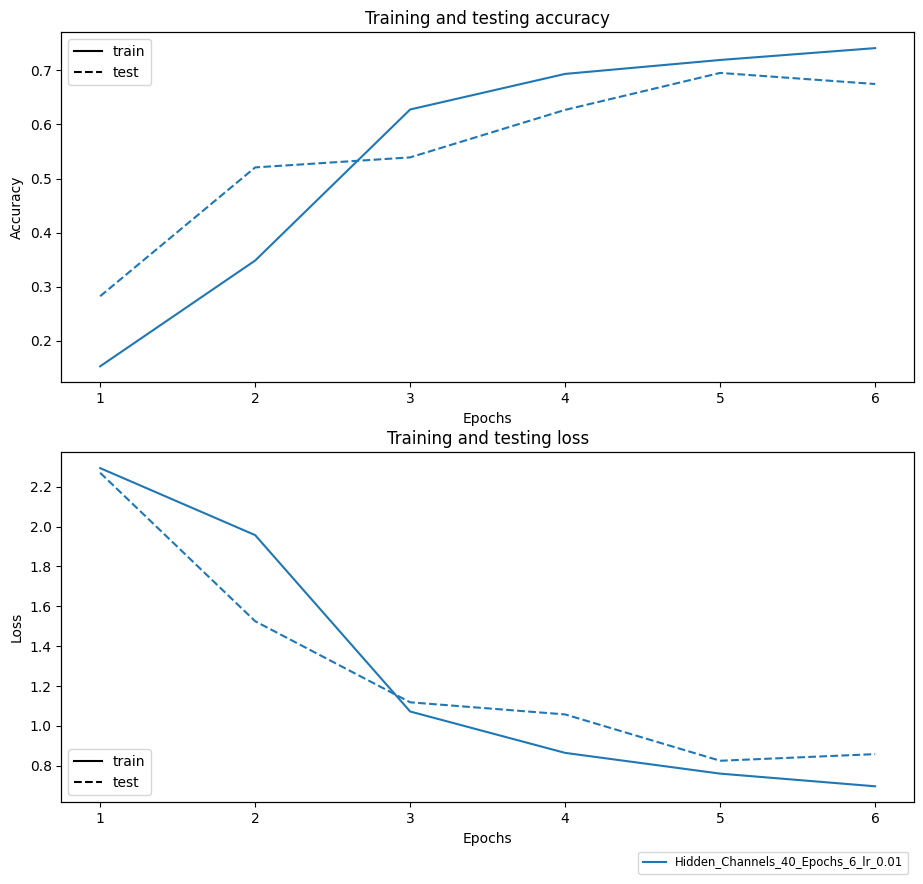

In [ ]:
#exp name and model name an extra are variables, not input arguments for retrieve, 
# because I need them for plot too :)
#the retrieve has the filter for experiment_name, model_name, extra
#the plot has no filter because it is hard :-: maybe in the future
#If you specified an argument in the retrieve it wont show in the label, so 
#add it to the title when plotting. 


import matplotlib.pyplot as plt 
import pandas as pd
from utils.config import RESULTS_DIRECTORY
import numpy as np
from utils.helpers import retrieve_results
import itertools

resdf = retrieve_results(experiment_name="Test_plots",model_name="TinyVGG_1",extra="Hidden_Channels_40_Epochs_6_lr_0.01")

names = iter(resdf["Label"].unique()) # 1 label per feather file
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = itertools.cycle(colors)

fig,ax = plt.subplots(2,1,figsize=(11,10))

ax0 = ax[0].twinx()
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
ax1 = ax[1].twinx()
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)

ax[0].set_title("Training and testing accuracy")
ax[1].set_title("Training and testing loss")

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")

#for dataframe in ...########################################################################

col = next(color_cycle)
name = next(names)

ax[0].plot(resdf[["Epoch #"]],resdf[["train_acc"]],'-',color=col,label=name)
ax[0].plot(resdf[["Epoch #"]],resdf[["test_acc"]],'--',color=col) 

ax[1].plot(resdf[["Epoch #"]],resdf[["train_loss"]],'-',color=col,label=name)
ax[1].plot(resdf[["Epoch #"]],resdf[["test_loss"]],'--',color=col)

ax[1].legend(loc=1,fontsize="small",bbox_to_anchor=(1, -0.125)) # Legend for colors in loss

#out of the for##############################################################################


ax0.plot(np.nan,np.nan,'-',label="train",color ='black')
ax0.plot(np.nan,np.nan,'--',label="test",color='black')
ax0.legend(loc=2) # Legend for train test in acc

ax1.plot(np.nan,np.nan,'-',label="train",color ='black') 
ax1.plot(np.nan,np.nan,'--',label="test",color='black')
ax1.legend(loc=3) # Legend for train test in loss

#fig.legend(loc="center")

plt.show()


In [ ]:
from utils.helpers import retrieve_results
from utils.helpers import plot_results

experiment_name = "Test_plots"
model_name = None 
extra = None

resdf = retrieve_results(experiment_name="Test_plots")#,model_name="TinyVGG_1",extra="Hidden_Channels_40_Epochs_6_lr_0.01")


   Hidden_Channels  Epochs     lr  train_loss  train_acc  test_loss  test_acc  \
0               40       6  0.001    2.300779   0.100233   2.297978  0.124023   
1               40       6  0.001    2.298735   0.121177   2.295792  0.135742   
2               40       6  0.001    2.296610   0.126828   2.293447  0.159180   
3               40       6  0.001    2.294279   0.125997   2.290784  0.182617   
4               40       6  0.001    2.291416   0.169215   2.287474  0.191406   
5               40       6  0.001    2.287872   0.162566   2.283183  0.193359   

   Epoch #                                           Label  
0        1  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  
1        2  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  
2        3  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  
3        4  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  
4        5  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  
5        6  TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001  


   

In [ ]:
subfolders = [ f.name for f in os.scandir(RESULTS_DIRECTORY) if f.is_dir()]
print(subfolders)

['Test_dataframe', 'Test_plots']


In [15]:
resdf.head()

,Hidden_Channels,Epochs,lr,train_loss,train_acc,test_loss,test_acc,Epoch #,Label
0,40,6,0.001,2.300779,0.100233,2.297978,0.124023,1,TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001
1,40,6,0.001,2.298735,0.121177,2.295792,0.135742,2,TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001
2,40,6,0.001,2.296610,0.126828,2.293447,0.159180,3,TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001
3,40,6,0.001,2.294279,0.125997,2.290784,0.182617,4,TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001
4,40,6,0.001,2.291416,0.169215,2.287474,0.191406,5,TinyVGG_1_Hidden_Channels_40_Epochs_6_lr_0.001


In [ ]:
import numpy as np
# To normalize the epochs
big = np.array(np.linspace(1,100,100))
mid = np.linspace(1,20,20)
small = np.array(np.linspace(1,5,5))

small = small * 100/5
mid = mid * 100/20

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

---------------------------------

In [3]:
from utils.helpers import retrieve_metadata

retrieve_metadata(experiment_name="Test_new_metadata",model_name="Model_3",extra="Hidden_Channels_40_Epochs_2_lr_0.001")

{'date': '28-08-2025 13:28',
 'experiment name': 'Test_new_metadata',
 'model name': 'Model_3',
 'learning rate': 0.001,
 'epochs': 2,
 'loss function': 'CrossEntropyLoss',
 'optimizer name': 'SGD',
 'dataset': 'FashionMNIST',
 'training dataset size': 6000,
 'testing dataset size': 1000,
 'batch size': 32,
 'Hyperparams': {'Hidden_Channels': [40], 'Epochs': [2], 'lr': [0.001]},
 'optimizer params': {'lr': 0.001,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None},
 'model params': {'layer_1': Sequential(
    (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  ),
  'layer_2': Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3)

In [231]:
type(HYPERPARAMETERS.keys())

dict_keys

In [141]:
from utils.helpers import retrieve_metadata
import pandas as pd
retrieve_metadata(experiment_name="Test_dataframe",model_name="TinyVGG_1",extra="Hidden_Channels_40_Epochs_2_lr_0.01")
dataframe_path = os.path.join(RESULTS_DIRECTORY,"Test_dataframe","TinyVGG_1","Hidden_Channels_40_Epochs_2_lr_0.01")

pd.read_feather(dataframe_path)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\experiment_logs\\results\\Test_dataframe\\TinyVGG_1\\Hidden_Channels_40_Epochs_2_lr_0.01'

In [142]:
A = [1,2,3]
A[:-1]

[1, 2]